In [91]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, join
import os
empty_fits_dir = "/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits"
os.chdir(empty_fits_dir)

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,6)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli stuff
from grizli.model import GrismFLT
import pysynphot as S
import webbpsf
import webbpsf.roman

from math import ceil

In [92]:
bandpass_file = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits"
spec_file = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat"

# Read SED template; using G0V star template
df = Table.read(bandpass_file, format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Adjust spectrum as appropriate
spec = Table.read(spec_file, format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"], waveunits="angstroms", fluxunits="flam")
src = src.renorm(6, "abmag", bp)
src.convert("flam")

# Truncate and put in astropy table for ease-of-use
start_idx = np.where(src.wave == 10000)[0][0]
end_idx = np.where(src.wave == 20000)[0][0] + 1

old_wave_array = src.wave[start_idx:end_idx]
old_flux_array = src.flux[start_idx:end_idx]

new_wave_array = np.arange(10000, 20000 + 1, 1)
new_flux_array = np.interp(new_wave_array, old_wave_array, old_flux_array)

spec = Table([new_wave_array, new_flux_array], names=("wave", "flux"), dtype=(np.float64, np.float64))

# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

In [93]:
# initialize grizli
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad);

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [94]:
def chunk(start_wave, end_wave):
    """
    This function returns a small region of the spectrum.
    """

    # print(start_wave, end_wave)

    start_idx = np.where(spec["wave"] == start_wave)[0][0]
    end_idx = np.where(spec["wave"] == end_wave)[0][0] + 1

    chunk_spec = np.asarray(spec[start_idx:end_idx])

    return chunk_spec

def dispersion_model(spectrum_overlap, npsfs, return_input=False):
    """
    This function controls/guides the dispersion process. It sets up the appodizing window,
    chops the spectrum into smaller segments, and iteratively disperses each segment. If 
    return_input is True, it returns a list containing the input segments then the grism sim.
    The input segments can be stitched together using the combine_overlaps function below. 

    Parameters
    ----------

    spectrum_overlap: int
        The number of data points that overlap as spectrum segments roll-on/off.
    
    npsfs: int
        The number of distinct PSFs to be used. Also, the number of spectrum segments.
    """
    spectrum_overlap = int(spectrum_overlap) # overlap extent; data points
    npsfs = int(npsfs) # number of bins

    window_x = np.linspace(0, np.pi, spectrum_overlap)
    front_y = (1-np.cos(window_x)) / 2
    back_y = 1 - front_y

    bins = np.linspace(10000, 20000, npsfs + 1)

    piecemeal_sim = np.zeros((4288,4288))

    input_catcher = []
    
    for ii, start_wave in enumerate(bins[:-1]):

        psf = wfi.calc_psf(monochromatic=(start_wave * (10**-10)), fov_pixels=364, oversample=1, source=src)[0].data
        half_psf_thumb = int(psf.shape[0] / 2) # Used for indexing; center_pixel plus/minus half_psf_thumb(nail)
        
        direct = np.zeros((4288, 4288))
        direct[(2144-half_psf_thumb): (2144+half_psf_thumb), (2144-half_psf_thumb):(2144+half_psf_thumb)] = psf

        roman.direct.data["SCI"] = direct.astype("float32")
        roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

        end_wave = bins[ii+1]

        start_wave -= spectrum_overlap * 0.5
        end_wave += spectrum_overlap * 0.5 - 1

        if start_wave < 10000:
            start_wave = 10000
        
        if end_wave > 20000:
            end_wave = 20000

        chunk_spec = chunk(start_wave, end_wave) # extract relevant part of spectrum
        wave = chunk_spec["wave"]
        flux = chunk_spec["flux"]

        # apodize
        if start_wave != 10000:
            flux[:spectrum_overlap] *= front_y

        if end_wave != 20000:
            flux[-spectrum_overlap:] *= back_y

        # print("Wave Limits: [{}, {}]".format(wave[0], wave[-1])) # used for troubleshooting
        
        single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=500, is_cgs=True, store=False,
                                                       in_place=False, spectrum_1d=[wave, flux])[1]

        piecemeal_sim += single_dispersion

        apodized_spec = Table([wave, flux], names=("wave","flux"))

        input_catcher.append(apodized_spec)

        del chunk_spec
        del flux
        del wave

    return_collector = []

    if return_input:
        return_collector.append(input_catcher)

    return_collector.append(piecemeal_sim)

    return return_collector

def combine_overlaps(table_1, table_2):
    """
    This function can be used in a for loop to stitch together the input spectrum segments.
    """

    full_input = join(table_1, table_2, keys='wave', join_type="outer")

    full_input["flux_1"].fill_value = 0
    full_input["flux_2"].fill_value = 0
    full_input = full_input.filled()

    sum = full_input["flux_1"] + full_input["flux_2"]

    sum_table = Table([full_input["wave"], sum], names=["wave", "flux"])

    return sum_table

def simple_extractions(image, sum=True, max=False):
    """
    Scans along the columns of the pixel array. Hyper-simplified "extraction."
    """

    return_collector = []

    if sum:
        return_collector.append(np.array([image[:, ii].sum() for ii in range(image.shape[1])]))
    
    if max:
        return_collector.append(np.array([image[:, ii].max() for ii in range(image.shape[1])]))

    return return_collector

In [95]:
np.where(spec["wave"] == 20000)

(array([10000]),)

In [96]:
# Run the simulation
spectrum_overlap = 100
npsfs = 20

inputs, sim_result = dispersion_model(spectrum_overlap, npsfs, return_input=True)

10000 10549.0
10450.0 11049.0
10950.0 11549.0
11450.0 12049.0
11950.0 12549.0
12450.0 13049.0
12950.0 13549.0
13450.0 14049.0
13950.0 14549.0
14450.0 15049.0
14950.0 15549.0
15450.0 16049.0
15950.0 16549.0
16450.0 17049.0
16950.0 17549.0
17450.0 18049.0
17950.0 18549.0
18450.0 19049.0
18950.0 19549.0
19450.0 20000


In [97]:
# Combine all inputs into a single array
for ii in range(len(inputs)):
    if ii == 0:
        full_input = inputs[0]
    else:
        full_input = combine_overlaps(full_input, inputs[ii])

# Perform simple_extractions
extractions = simple_extractions(sim_result, sum=True, max=True)

Text(0.5, 1.0, 'Extractions')

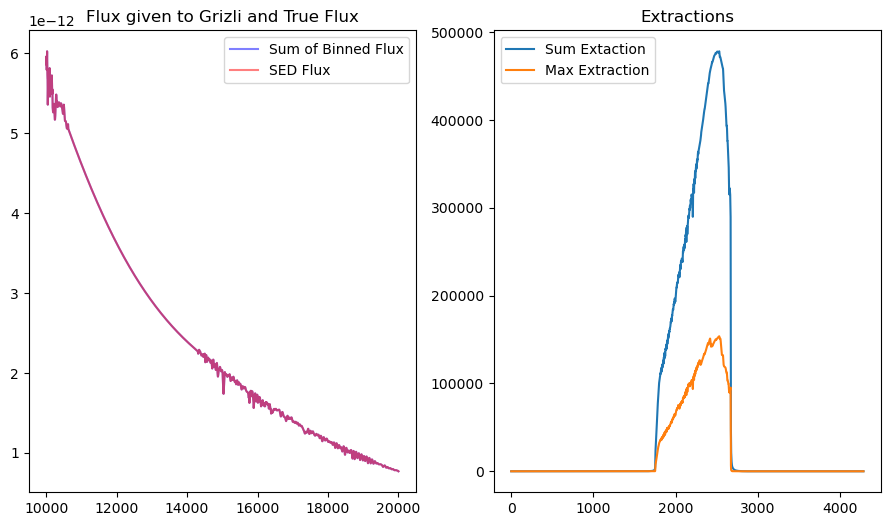

In [100]:
# Plot the inputs and extractions
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(full_input["wave"], full_input["flux"], color='b', alpha=0.5, label="Sum of Binned Flux")
ax1.plot(spec["wave"], spec["flux"], color = 'r', alpha=0.5, label="SED Flux")
ax1.legend()
ax1.set_title("Flux given to Grizli and True Flux")

ax2.plot(extractions[0], label="Sum Extaction")
ax2.plot(extractions[1], label="Max Extraction")
ax2.legend()
ax2.set_title("Extractions")

In [101]:
# Calculate a simple, single-PSF model for comparison
truth = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=500, is_cgs=True, 
                                   store=False, in_place=False, spectrum_1d=[spec["wave"], spec["flux"]])[1]

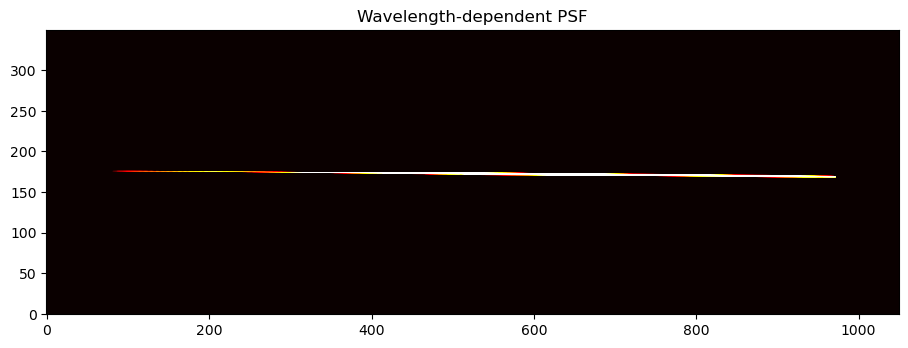

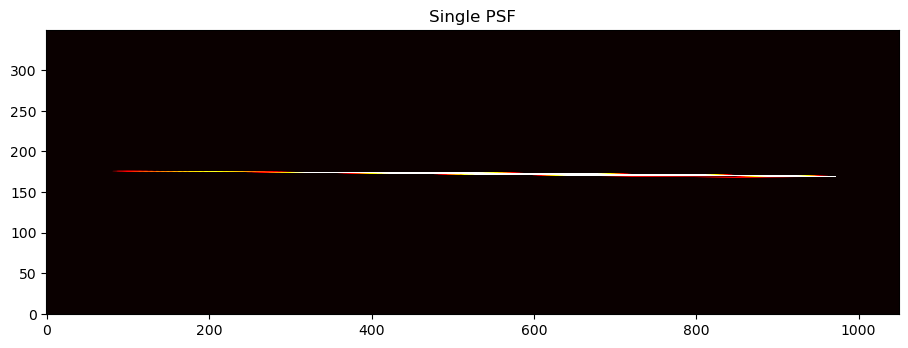

In [102]:
plt.imshow(np.log(sim_result[2000:2350, 1700:2750])-10, vmin=0, vmax=1, cmap="hot")
plt.title("Wavelength-dependent PSF")
plt.show()

plt.imshow(np.log(truth[2000:2350, 1700:2750])-10, vmin=0, vmax=1, cmap="hot")
plt.title("Single PSF")
plt.show()

Text(0.5, 1.0, 'Subtract Wavelength-depdent PSF dispersion from Single PSF disperion')

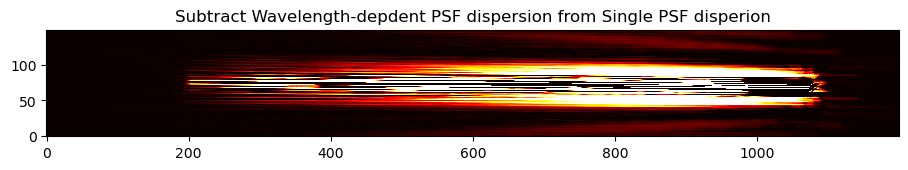

In [103]:
plt.imshow((truth-sim_result)[2100:2250, 1600:2800], vmin=0, vmax=sim_result.max()/1000, cmap="hot")
plt.title("Subtract Wavelength-depdent PSF dispersion from Single PSF disperion")

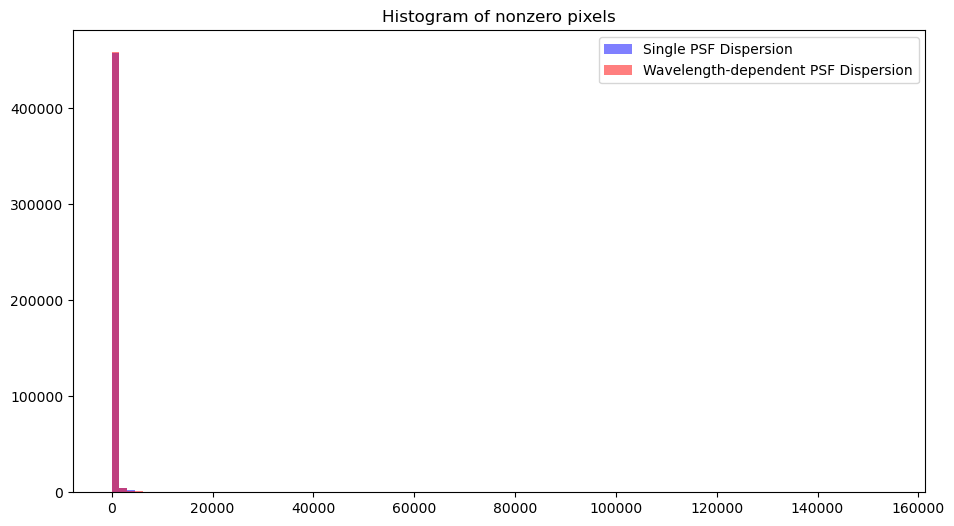

In [104]:
plt.hist(truth[np.nonzero(truth)].flatten(), bins=100, color="b", alpha=0.5, label="Single PSF Dispersion");
plt.hist(sim_result[np.nonzero(sim_result)].flatten(), bins=100, color="r", alpha=0.5, label="Wavelength-dependent PSF Dispersion");
plt.title("Histogram of nonzero pixels")
plt.legend()